In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Estrutura de um modelo ANN

* A seguir descreveremos toda a estrutura de um modelo de redes neurais artificias.   
Este código serve para entender e estudar o comportamento das funções de ativação adaptação de peso e de bias e aprendizado da rede.   

In [29]:
colors = { 'rosa':'#ff66c4' ,'azul':'#5271ff' , 'verde':'#7ED957' , 'laranja':'#f6672a' }
#usa um background escuro de fundo
plt.style.use('dark_background')
#plt.rcParams é um dicionário global que contém parâmetros de configuração para matplotlib. 
plt.rcParams['figure.figsize'] = (8,6)
#configura a largura padrão das linhas nos gráficos para 3 pontos. 
plt.rcParams['lines.linewidth'] = 3
#Define o tamanho padrao da fonte
plt.rcParams['font.size'] = 15
#Esta linha cria um dicionário bbox que define as propriedades de uma caixa de texto (ou rótulo) que pode ser usada em gráficos
bbox = dict(boxstyle='round', alpha=0.7, color=colors['rosa'])



* Usaremos como função de ativação a função sigmoide, está função esta descrita no codigo abaixo.     
Ela tem a seguinte formula: 


    *  $ y = \frac{1}{ {1} + {e}^{-x}} $


In [30]:
# ativação da função sigmoid
def ativacao_sigmoid(x: float) -> float:
    return (1/ (1+np.e**(-x)))

* A seguir criamos os dados que ja estão normalizados, em seguida mostramos esses pontos no gráfico o que nos mostra a curva que esses dados fazem.    
O objetivo desta rede neural é criar uma curva que modele estes pontos que estão plotados abaixo. 

Text(0.5, 1.0, 'Valor do seguro em função da idade (Com valores normalizados)')

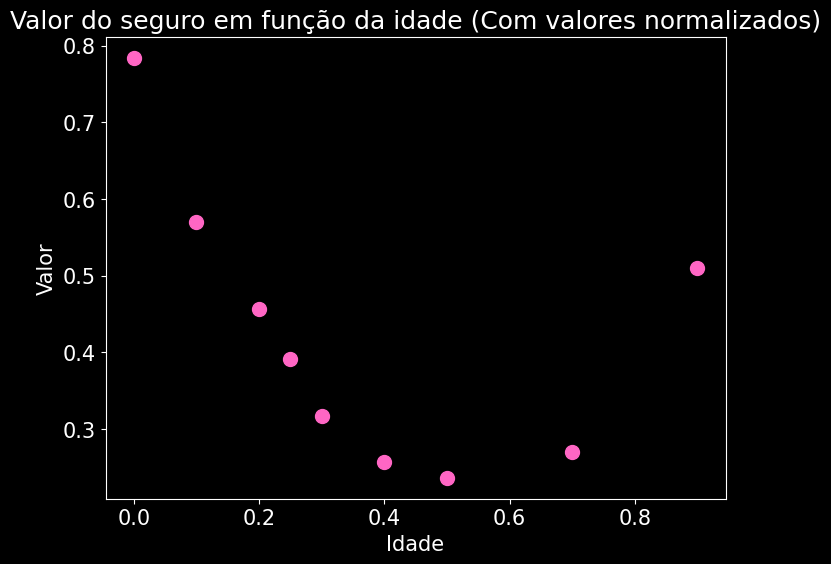

In [31]:
#Definição dos valores do array idade
idade = np.array([0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 0.9])
#Definição dos valores do array valor
'''
Para cada x em idade, é calculado o valor de uma função quadrática modificada por um ruído aleatório.


((x - 0.3)**2 - 0.45*x + 0.3)*2: Essa é uma função quadrática onde x é a idade.


np.random.randn()/60: Gera um valor aleatório da distribuição normal (com média 0 e desvio padrão 1)
e divide por 60 para que o ruído seja pequeno.
+ np.random.randn()/60: Adiciona o ruído ao valor calculado para introduzir variação nos dados.
'''
valor = np.array([((x - 0.3)**2 - 0.45*x + 0.3)*2 + np.random.randn()/60 for x in idade])
#Cria um gráfico de scatter
plt.scatter( idade, valor, s= 100, color=colors['rosa'])  #s=100 Tamanho dos pontos no gráfico.
plt.xlabel('Idade')
plt.ylabel('Valor')
plt.title('Valor do seguro em função da idade (Com valores normalizados)')



In [32]:
#Cria um dataframe com os valores de idade e valor
df = pd.DataFrame({'idade': idade, 'valor':valor})

* Abaixo ajustamos os valores do dataframe para converte-los em tensores, também seguimos um passo a passo para deixar estes tensores de mesmo tamanho para ser possível as análises futuras.

In [34]:
x = torch.FloatTensor([df.idade.values.astype(float)])
# x é agora um tensor de ponto flutuante com uma única linha contendo os valores da coluna 'Idade'
y = torch.FloatTensor([df.valor.values.astype(float)])
# y é agora um tensor de ponto flutuante com uma única linha contendo os valores da coluna 'Valor'
y = y.squeeze()
# y.squeeze()  retira uma dimensao do tensor
y= y.unsqueeze(1)
# y.unsqueeze(1) adiciona uma dimensão ao tensor y na posição 1
# Se y tinha shape [m], x agora terá shape [m, 1]
x = x.view(x.size(1), -1)
# x.size(1) retorna o tamanho da segunda dimensão de x, que é m
# x.view(x.size(1), -1) reorganiza o tensor para ter shape [m, n], onde n é inferido automaticamente
# Isso resulta em um tensor y com shape [m, n]






In [35]:
print("tamanho do tensor x",x.shape)
print("tamanho do tensor y",y.shape)

torch.Size([9, 1])

## Criação da Rede Neural

* A seguir criamos a rede neural propriamente dita, especificando os neurônios da rede, da camada de entrada, de saida e da camada escondida.    
Aqui esta uma representação gráfica da rede neural:   
   
   ![ANN](\data\data\kaio\redeneural.png) 


* A rede neural possui uma cama de entrada,uma camada de saida e dois neurônios na camada escondida.   
Esta rede não é tão complexa, porém ainda possibilita um ótimo estudo de sua rotina e de suas funções de ativação e com isso podemos estudar sua complexidade. 

In [38]:
class Model(nn.Module):
    #Inicializa a classe com um argumento hidden_neurons que define o número de neurônios na camada oculta (o valor padrão é 2).
    def __init__(self, hidden_neurons=2):
        super(Model, self).__init__()
        # Armazena o número de neurônios da camada oculta em um atributo da instância.
        self.hidden_neurons = hidden_neurons
        #Define uma camada linear de entrada que mapeia 1 entrada para 2 saídas (neurônios) com um viés e tipo de dados float32.
        self.input_layer = nn.Linear(in_features=1, out_features=2,bias=True,dtype=torch.float32)
        # Define uma camada linear de saída que mapeia 2 entradas (neurônios ocultos) para 1 saída.
        self.output_layer = nn.Linear(in_features=2, out_features=1)
        #Define a função de ativação Sigmoid a ser usada após a camada de entrada.
        self.activation = nn.Sigmoid()

    # Define o método forward, que recebe como entrada x.
    def forward(self, x):
        # Passa a entrada x pela camada de entrada.
        out = self.input_layer(x)
        # Aplica a função de ativação Sigmoid ao resultado da camada de entrada.
        out = self.activation(out)
        # Passa o resultado pela camada de saída.
        out = self.output_layer(out)
        # Retorna a saída final da rede
        return out
      

* Abaixo está a definição de epocas que o modelo será treinado e sua taxa de aprendizado.

In [39]:
# Define o tamanho de epocas que a serie será treinada
EPOCH = 1000
# Define a Taxa de aprendizado da serie 
LR = 0.1


* Aqui instanciamos os modelos os criterios de perda e o tipo de otimizador.

In [40]:
# Instancia o modelo
model = Model()
# define a função de perda que será usada para avaliar o desempenho do modelo durante o treinamento
# A função de perda escolhida é a MSELoss
criterion = nn.MSELoss()
# O otimizador escolhido é o Adam, que é um método de otimização adaptativa que combina as vantagens do AdaGrad e do RMSProp.
optimizer = torch.optim.Adam(params= model.parameters(), lr=LR)



* Abaixo começamos o treinamento do modelo propriamente dito, nos passos seguintes é:
  * calculado o próximo valor.
  * calculado a perda entre o valor previsto e original.
  * após isso o modelo otimiza a curva atráves do gradiente de perda.
  * e por final o modelo atualiza os pesos e os bias.

In [41]:
# Inicialização dos vetores de pesos e do bias
weights = []
bias = []
# O loop a seguir itera pelo numero de epocas definidas 
for epochs in range(EPOCH):
    # o modelo faz a passagem direta (forward pass) usando os dados de entrada x.
    # A função forward calcula as previsões do modelo com base nos pesos atuais.
    outputs = model.forward(x)
    # a perda (erro) entre as previsões do modelo (outputs) e os valores reais (y) é calculada 
    loss = criterion(outputs,y)
    # zera os gradientes acumulados dos parâmetros do modelo.
    # Isso é necessário porque os otimizadores acumulam gradientes por padrão,
    # então precisamos zerar antes de calcular os novos gradientes nesta época.
    optimizer.zero_grad()
    # faz a retropropagação (backward pass) para calcular os gradientes da perda em relação aos pesos do modelo. 
    # A função backward propaga o erro de saída para entrada e calcula os gradientes dos pesos.
    loss.backward()
    # o otimizador atualiza os pesos do modelo com base nos gradientes calculados
    optimizer.step()
    # adicionam os pesos e bias (sesgos) da camada de entrada do modelo às listas weights e bias
    weights.append(model.input_layer.weight)
    bias.append(model.input_layer.bias)
out = outputs    

* Nos passos abaixo podemos ver os pesos e os bias da camada de entrada.

In [42]:
print(f'Camada de Entrada:')
print(f'Pesos: {model.input_layer.weight.view(-1).numpy(force=True)}\nBias:{model.input_layer.bias.view(-1).numpy(force=True)}')

Camada de Entrada:
Pesos: [-4.7548594  5.705584 ]
Bias:[-0.38153666 -6.09256   ]


* Nos passos abaixo podemos ver os pesos da camada de saida e o seu bias.

In [43]:
print(f'Camada Escondida:')
print(f'Pesos: {model.output_layer.weight.view(-1).numpy(force=True)}\nBias:{model.output_layer.bias.view(-1).numpy(force=True)}')

Camada Escondida:
Pesos: [1.7413881 1.5357982]
Bias:[0.0665491]


* Os passos que seguem abaixo fazem com que seja possível visualizar as curvas que adaptam os dados de entrada e de saida, a partir destes passos de treinamento do modelo que foram feitos nas células anteriores.

In [44]:
# Converte um tensor torch em uma array numpy
def tensor_to_numpy(tensor: torch.tensor):
    '''
    O método view(-1) é usado para achatar o tensor em uma única dimensão. 
    Se o tensor original tinha múltiplas dimensões, ele será transformado em um vetor unidimensional.
    O método numpy() converte o tensor PyTorch em um array NumPy.
    A flag force=True tenta fazer a conversão mesmo se o tensor não estiver armazenado de maneira contígua na memória.
    '''
    return tensor.view(-1).numpy(force=True)

In [45]:
# A linha de código fornecida cria um aaray numpy que conberte para
# tensor PyTorch com valores de ponto flutuante que variam de 0 a 1 (exclusivo), com um incremento de 0.02.
x_range = torch.FloatTensor(np.arange(0,1.0,0.02))

In [46]:
#  Esta linha calcula a entrada linear (y1) para a unidade da camada de entrada correspondente.
#  model.input_layer.weight[0][0]: O peso associado à primeira unidade da camada de entrada do modelo.
#  model.input_layer.bias[0]: O bias associado à primeira unidade da camada de entrada do modelo.
y1 = x_range*model.input_layer.weight[0][0] + model.input_layer.bias[0]
# Esta linha aplica a função de ativação sigmoide à entrada linear y1.
sigmoid1 = 1/(1 + torch.exp(-y1))
# saida1: A saída da unidade após a função de ativação sigmoide ser aplicada
# e a ponderação pela primeira unidade da camada de saída.
# model.output_layer.weight[0][0]: O peso associado à primeira unidade da camada de saída do modelo.
saida1 = sigmoid1*model.output_layer.weight[0][0]

In [47]:
# converte as linhas anteriores em vetores numpy
y1_numpy = tensor_to_numpy(y1)
sigmoid1_numpy = tensor_to_numpy(sigmoid1)
saida1_numpy = tensor_to_numpy(saida1)

* Com todos estes passos feitos pode-se agora plotar os neurônios de "cima" da rede neural sendo o somatorio da entrada da camada escondida e da camada de saida.   
Com isto podemos ver como as funções são adaptadas para cirar estas curvas e também os passos que acontecem por trás das redes neurais artificias.

Text(0.5, 1.0, 'somatorio')

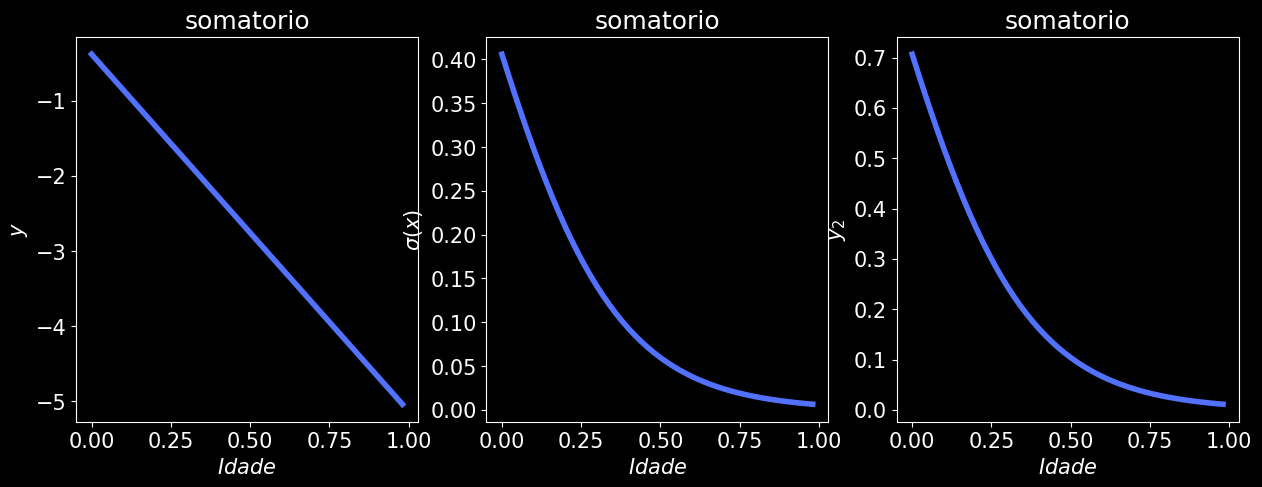

In [48]:
# Neuronios da parte de cima da rede neural
fig ,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

#somatorio perceptron
ax[0].plot(x_range,y1_numpy,lw=4,color=colors['azul'])
ax[0].set_xlabel(r'$Idade$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('somatorio - reta')


#Ajuste da sigmoid
ax[1].plot(x_range,sigmoid1_numpy,lw=4,color=colors['azul'])
ax[1].set_xlabel(r'$Idade$')
ax[1].set_ylabel(r'$\sigma(x)$')
ax[1].set_title('somatorio - sigmoid')


#Curva da saida
ax[2].plot(x_range,saida1_numpy,lw=4,color=colors['azul'])
ax[2].set_xlabel(r'$Idade$')
ax[2].set_ylabel(r'$y_2$')
ax[2].set_title('somatorio - saida')

* Os passos para visualização da rede neural agora são feitos para os neurônios de "baixo", em seguida podemos ver as curvas que a rede neural constrói para a parte de baixo.

In [49]:
#  Esta linha calcula a entrada linear (y2) para a unidade da camada de entrada correspondente.
#  model.input_layer.weight[1][0]: O peso associado à segunda unidade da camada de entrada do modelo.
#  model.input_layer.bias[1]: O bias associado à segunda unidade da camada de entrada do modelo.
y2 = x_range*model.input_layer.weight[1][0] + model.input_layer.bias[1]
# Esta linha aplica a função de ativação sigmoide à entrada linear y2.
sigmoid2 = 1/(1 + torch.exp(-y2))
# saida2: A saída da unidade após a função de ativação sigmoide ser aplicada
# e a ponderação pela segunda unidade da camada de saída.
# model.output_layer.weight[0][1]: O peso associado à segunda unidade da camada de saída do modelo.
saida2 = sigmoid2*model.output_layer.weight[0][1]

In [50]:
# Conversão dos tensores anteriores em vetores numpy
y2_numpy = tensor_to_numpy(y2)
sigmoid2_numpy = tensor_to_numpy(sigmoid2)
saida2_numpy = tensor_to_numpy(saida2)

* Com os passos que foram feitos acima é possível ver as curvas dos neurônios de "baixo" da rede neural.    
Abaixo vemos as curvas de somatorio do neurônio de entrada do neurônio da camada escondida e do neurônio de saida, estas curvas adaptam a parte de baixo da rede neural a partir do aprendizado que foi feito anteriormente no modelo.

Text(0.5, 1.0, 'somatorio')

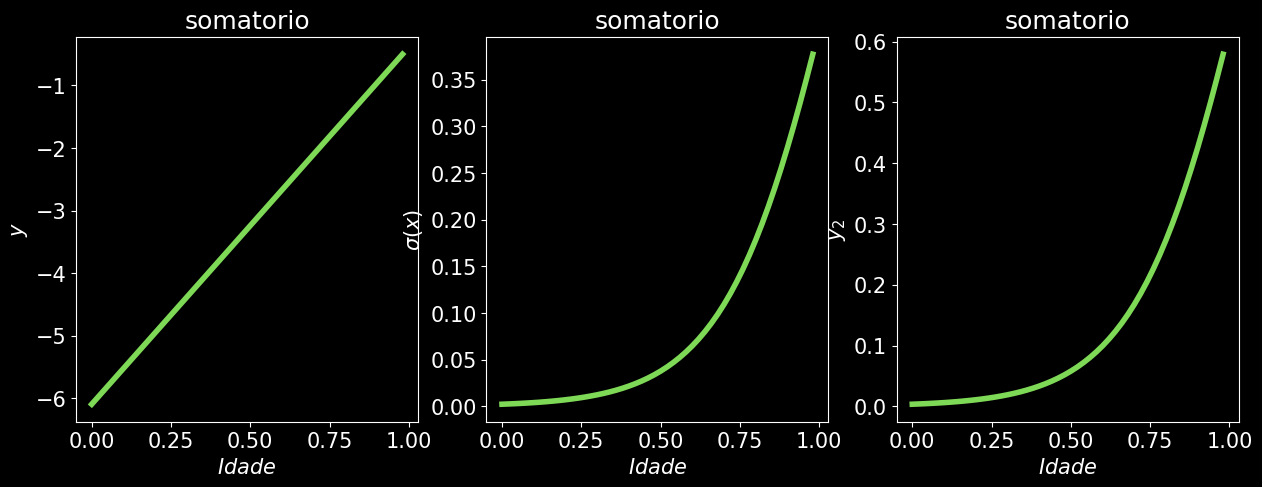

In [51]:
# Para os neuronios de baixo
fig ,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

# Somatorio perceptron
ax[0].plot(x_range,y2_numpy,lw=4,color=colors['verde'])
ax[0].set_xlabel(r'$Idade$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('somatorio - reta')


# Ajuste da sigmoid
ax[1].plot(x_range,sigmoid2_numpy,lw=4,color=colors['verde'])
ax[1].set_xlabel(r'$Idade$')
ax[1].set_ylabel(r'$\sigma(x)$')
ax[1].set_title('somatorio - sigmoid')


# Curva de ponos da saida
ax[2].plot(x_range,saida2_numpy,lw=4,color=colors['verde'])
ax[2].set_xlabel(r'$Idade$')
ax[2].set_ylabel(r'$y_2$')
ax[2].set_title('somatorio - saida')

* A partir destas curvas que foram adaptadas podemos visualizar a junção destes neurônios no gráfico da esquerda e como eles ficam próximos da curva dos dados do dataframe.   
É possível perceber que a curva que a rede neural construiu não acompanho os dados na altura correta, porém estes dados conseguiram seguir bem a curva, isto ocorre pois ainda não foi somado o bias aos dois neurônios de saida. 

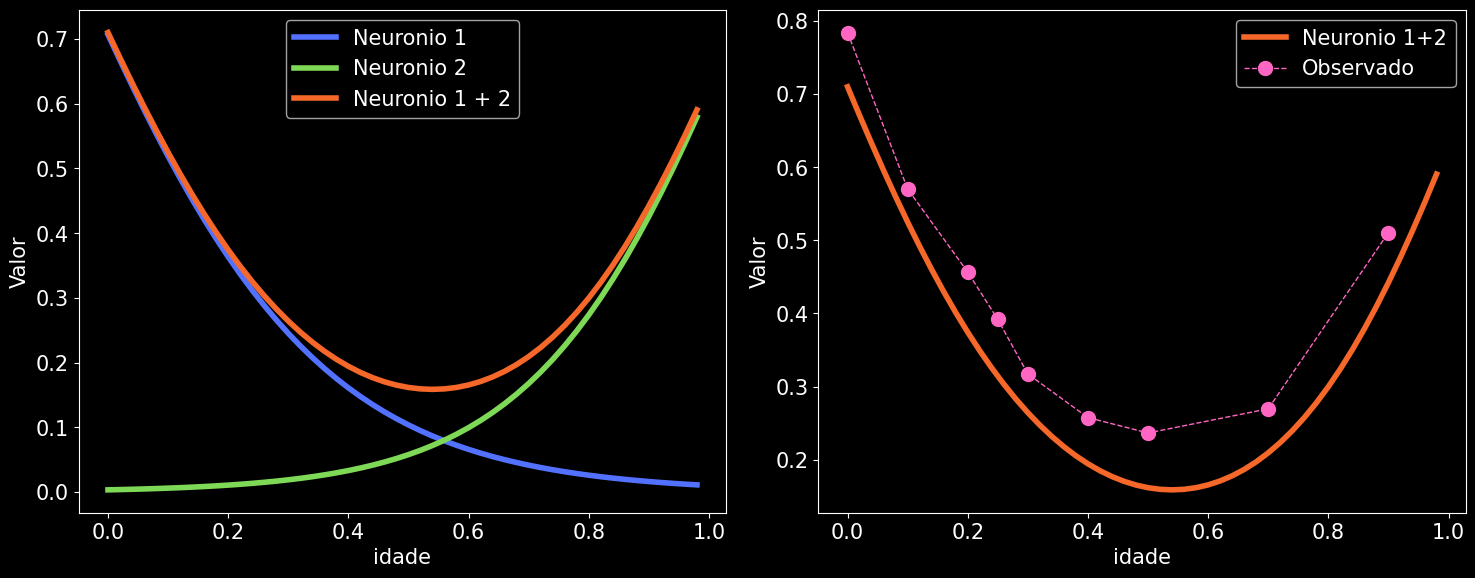

In [52]:
# Plotagem da soma de neuronios
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# Plot do primeiro neuronio
ax[0].plot(x_range, saida1_numpy, lw=4, color=colors['azul'], label='Neuronio 1')
# Plot do segundo neuronio
ax[0].plot(x_range, saida2_numpy, lw=4, color=colors['verde'], label='Neuronio 2')
# Plot do primeiro neuronio mais o segundo neuronio
ax[0].plot(x_range, saida1_numpy + saida2_numpy, lw=4, color=colors['laranja'], label='Neuronio 1 + 2')
ax[0].set_xlabel('idade')
ax[0].set_ylabel('Valor')
ax[0].legend()
# Plot do primeiro neuronio mais o segundo neuronio sem o bias
ax[1].plot(x_range,saida1_numpy + saida2_numpy,  lw=4, color=colors['laranja'], label='Neuronio 1+2')
# Plot da curva original dos dados
ax[1].plot(x, y,linestyle='dashed',color=colors['rosa'], lw=1, marker='o', markerfacecolor=colors['rosa'], markersize=10, label='Observado')
ax[1].set_xlabel('idade')
ax[1].set_ylabel('Valor')
ax[1].legend()

plt.tight_layout(pad=1)

In [53]:
# Criação a saida juntamente com o bias de saida para criar a curva que acompanha os pontos
saida = saida1 + saida2 + model.output_layer.bias[0]
# Transformação da saida em tensores numpy
saida_numpy = tensor_to_numpy(saida)

* Com o passo que foi feito acima foi somado o bias ao neurônio de saida e assim podemos visualizar como esta curva se adapta aos dados originais.   
É possivel perceber como a curva da previsão se adaptou bem aos dados e assim consegue prever de forma aproximada os valores do dataframe.

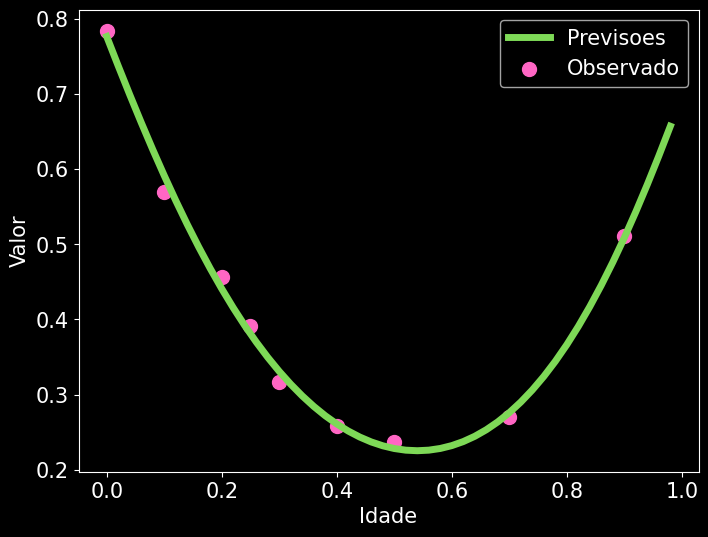

In [54]:
# Plotagem da saida com o bias de saida
plt.plot(x_range, saida_numpy,color=colors['verde'], lw= 5,label='Previsoes')
# Plot dos pontos originais 
plt.scatter(x,y,color=colors['rosa'],marker='o',s=100,label='Observado')
plt.xlabel('Idade')
plt.ylabel('Valor')
plt.legend()

* Assim termina o estudo de como é a contrução e previsão de uma rede neural artificial.